The purpose of this technical challenge is to take raw Illumina NGS data from an AlphaSeq experiment, execute data processing and visualize the resulting protein interactions using a heatmap. The main evaluation criteria is to complete each of the tasks succesfully. Feel free to get creative around how to get to the solution for eack task - even if it involves importing a different library or deviating from the instructions. 

The challenge requires Python 3 and the libraries below.  All of the processing steps can be completed with a few Pandas functions, but feel free to swtich up the implementation or bring in any other resources you think would be useful.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from collections import Counter

# Part 1

The first step is to read FASTQ files containing the sequencing reads, extract the barcode-barcode pairs and build a dataframe containing these barcode pairs

In [2]:
#Directory location of FASTQ files

fastq_directory_R1 = './S1_S1_R1_001.fastq'
fastq_directory_R2 = './S1_S1_R2_001.fastq'

Task #1: Write a function 'read_fastq_F' that reads both FASTQ files, extracts n number of sequencing reads and outputs a dataframe with two columns containing each paired sequencing reads. Enable functionality to extract up to a N number of reads - this is useful when trying to get a preview of a very large dataset. Extract 100,000 sequencing reads and save the output of your function as df1.  

Note: 
- Read 1 (R1) and read 2 (R2) files correspond to forward and reverse reads of the same molecule in the Illumina platform. Therefore, the number of reads in both files is the same and the total number of reads in the files corresponds to how many molecules were sequenced
- Importantly, the order of the reads is conserved to indicate molecule pairing: Read #50 in R1 file and read #50 in the R2 file correspond to the same molecule
- In AlphaSeq, MATa barcodes are in the first 15 based of R1 while MATalpha barcodes are in the first 15 bases of R2
- Illumina FASTQ files explained:
https://support.illumina.com/bulletins/2016/04/fastq-files-explained.html

In [3]:
import sys

#################
# Write your work for task #1 here
def get_sequences(file, sample=None):
    """Returns a list of sequences from a FASTQ file"""    
            
    sequences = []    
    barcodes = []
    with open(file, 'r') as inf:
        nrows = sum(1 for row in inf) 
        num_records = nrows / 4
                   
        if sample == None:
            sample = num_records
            
        if sample > num_records:
            print('Sample is larger than the number of records')
            sys.exit(0)
        
        inf.seek(0)
        # Read four lines at a time
        for i in range(0, int(sample)*4, 4):        
            seq_id = next(inf)   # toss out
            sequence = next(inf) # parse this
            sequences.append(sequence)
            barcodes.append(sequence[:15])  # This line is used for step #2
            optional = next(inf) # toss out
            quality = next(inf)  # toss out
    return sequences, barcodes


def read_fastq_F(r1=fastq_directory_R1, r2=fastq_directory_R2, sample=None):
    """Returns a dataframe of sequences and barcodes"""
    # Get barcodes
    r1_seqs, r1_barcodes = get_sequences(r1, sample)
    r2_seqs, r2_barcodes = get_sequences(r2, sample)
      
    # Create dataframe and down sample if necessary
    df = pd.DataFrame()
    df['read1'] = r1_seqs#[:sample]
    df['r1_barcode'] = r1_barcodes#[:sample]
    df['read2'] = r2_seqs#[:sample]
    df['r2_barcode'] = r2_barcodes#[:sample]
    
    
    return df
#################

In [4]:
df1=read_fastq_F(fastq_directory_R1,fastq_directory_R2)
df1.to_csv('df1.csv')
#print(df1.head(10))
#df1.head(10)
len(df1)

3523105

# Part 2

Task #2: Extract the barcodes from both Illumina reads and create dataframe 'df2'. The barcodes correspond to the first 15 characters in the strings of R1 and R2.

Then, import "barcodes_run22.csv" to a dataframe 'barcodes'. This dataframe contains the map of which barcodes correspond to which protein.

In [5]:
#################
# Write your work for task #2 here
df2 = df1[['r1_barcode', 'r2_barcode']]  # I added functionality in part 1 to address this question
df2.columns = ['read1', 'read2']         # rename columns to match example
barcodes = pd.read_csv('barcodes_run22.csv')
#################

df2.to_csv('df2.csv')
print(df2.head(5))
print(barcodes.head(5))

             read1            read2
0  NGGTCCCTACTTTGC  TACGACGACATCGCA
1  GCCTTCGAGACGTCG  CATAACGCCGGGTCT
2  GGCGGTAATCGTTTT  ATATCTATGGAAGCG
3  GGCGGTAATCGTTTT  ATATCTATGGAAGCG
4  GGCGGTAATCGTTTT  ATATCTATGGAAGCG
    Strain       Name          Barcode Description
0  Alpha_1     BimBH3  ATATCTATGGAAGCG      BimBH3
1  Alpha_2  AlphaNeg1  CTATGAACATTCGTT   AlphaNeg1
2  Alpha_3  AlphaNeg2  ACGTTAATTAACAAT   AlphaNeg2
3  Alpha_4  AlphaNeg3  TCACCAAAGCCTGTG   AlphaNeg3
4  Alpha_5      ABFL1  ACAGTAATGACCAAG       aBFL1


# Part 3

Now you have two dataframes. Df2 contains the extracted barcodes from the NGS run, and the barcodes dataframe contains a map of which barcode corresponds to which protein of interest. 

Task #3: Map the barcodes from read1 in df2 with the 'Barcode' field from the barcodes dataframe, then do the same for the barcodes from read2. Keep only reads with both read1 and read2 barcodes mapped. You should end up with a dataframe with 69,706 rows. Save the final dataframe as df3.

In [6]:
#################
# Write your work for task #3 here
df3 = (df2
       .merge(barcodes, left_on='read1', right_on='Barcode')
       .merge(barcodes, left_on='read2', right_on='Barcode')
      )
#################

print('Total reads: ' + str(len(df3)) + '\n---')
df3.to_csv('df3.csv')
print(df3.head(5))

Total reads: 2442771
---
             read1            read2 Strain_x Name_x        Barcode_x  \
0  GCCTTCGAGACGTCG  TTTCGAAAATTACTA      A_8   BCL2  GCCTTCGAGACGTCG   
1  GCCTTCGAGACGTCG  TTTCGAAAATTACTA      A_8   BCL2  GCCTTCGAGACGTCG   
2  GCCTTCGAGACGTCG  TTTCGAAAATTACTA      A_8   BCL2  GCCTTCGAGACGTCG   
3  GCCTTCGAGACGTCG  TTTCGAAAATTACTA      A_8   BCL2  GCCTTCGAGACGTCG   
4  GCCTTCGAGACGTCG  TTTCGAAAATTACTA      A_8   BCL2  GCCTTCGAGACGTCG   

  Description_x Strain_y Name_y        Barcode_y Description_y  
0          BCL2  Alpha_9  ABCL2  TTTCGAAAATTACTA         aBCL2  
1          BCL2  Alpha_9  ABCL2  TTTCGAAAATTACTA         aBCL2  
2          BCL2  Alpha_9  ABCL2  TTTCGAAAATTACTA         aBCL2  
3          BCL2  Alpha_9  ABCL2  TTTCGAAAATTACTA         aBCL2  
4          BCL2  Alpha_9  ABCL2  TTTCGAAAATTACTA         aBCL2  


# Part 4

The final step in pre-processing AlphaSeq data is to count how many times each protein pair was found in the data and to create an M by N dataframe containing a matrix of barcode pairs. 

Task #4: Create a dataframe containing a matrix of barcode pair counts where the columns represent proteins in the MATa strains while the rows represent proteins the MATalpha strains. Fill empty fields with a value of 0. 

Save final dataframe as df4. 

In [7]:
#################
# Write your work for task #4 here
df4 = pd.crosstab(df3['Name_y'], df3['Name_x'])
df4.columns.name = None  # Remove labels to match example
df4.index.name = None

# -- Note: The rows and columns are not sorted the same as the example. 
# -- I'm making the assumption that order isn't important.

##################


df4.to_csv('df4.csv')
df4

,AAYS_231,AAYS_232,AAYS_263,AAYS_265,AAYS_354,AAYS_356,AAYS_566,AAYS_567,AAYS_571,ANeg1,ANeg2,ANeg3,BCL2,BCLB,BCLXL,BCLw,BFL1
AAYS_242,5117,2752,23,45891,3307,65150,3103,4220,4319,1053,1950,2923,651,2365,2082,1995,985
AAYS_251,76,2,95163,2161,4239,1903,215,298,197,0,289,159,131,197,113,9,28
AAYS_378,0,0,5934,0,0,118,0,0,0,0,0,0,0,0,115,0,2
AAYS_379,297,124,126,3720,503,5236,170,104,244,185,1,133,7,286,199,0,41
AAYS_380,198,666,116486,1204,402,3053,170,367,279,166,1,154,34,122,281,11,98
AAYS_381,129,0,88706,835,376,1269,481,292,279,0,473,57,13,123,18,7,16
AAYS_382,207,281,167843,1632,394,1111,1,6,64,0,0,79,78,319,140,10,197
AAYS_383,0,0,2369,95,0,177,0,0,0,0,0,0,0,77,0,0,3
AAYS_384,0,0,1767,132,0,0,0,0,0,173,0,75,31,0,1,0,2
AAYS_540,413,99,17,3214,351,6186,141,86827,20724,0,0,0,54,147,123,242,168


# Part 5

The final part of this technical challenge is to create figures to visualize the AlphaSeq data. 

Task #5. Create a heatmap figure corresponding to the matrix of protein interactions that looks as similar as possible to the one below. Using matplotlib pcolor is the easy way, but feel free to deviate.

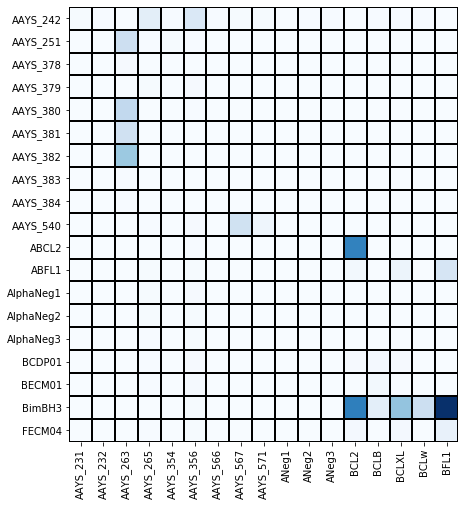

In [45]:
#################
# Write your work for task #5 here

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.heatmap(df4, cmap='Blues', linewidths=1, linecolor='black', cbar=False, square=True, rasterized=False, **{'linestyle':':'});


# Note: 
# This heatmap isn't an exact replica because it is sorted differently, but Seaborn 
# makes a darn good heatmap with one line of code



###########

# Part 6: Optional Problems

Finally, choose at least one of the following prompts, which should give you a chance to show off a range of relevant skills:

(6A) Create a second figure of your choice (heatmap, bar plot, scatter plot, etc) to visualize the entire dataset or a portion it. Justify your design choices. 

(6B) Design, justify and implement a statistical test assessing whether each Mat-A and Mat-Alpha pair interact significantly, utilizing the AlphaNeg and ANeg negative controls.  What statistical or experimental aproaches could be used to increase power?

(6C) Re-do part 3, but allow reads to be called if the observed barcode is within 1 edit distance of an expected barcode.

(6D) Propose and implement a set of QC metrics that can be used to assess the quality and reliability of the results.

(6E) Working backward from the exercise as given, draft a mini design doc including a detailed technical architecture for the overall analysis task that would allow any competent engineer to reproduce your work.

(6F) Propose and implement a meaningful utilization of the Q-values contained in the Fastq files

(6G) Determine the time and space complexity of the processing pipeline you've developed during this exercise; as we scale AlphaSeq to mat-A and mat-Alpha libraries of 10^4-10^5 and work with 10^8-10^9 input reads, which steps may become areas of concern for performance?  Do you have any ideas on how to improve complexity for those steps?

# 6a
### Create a second figure of your choice

---

As a self-proclaimed "data visualization nerd", I let my self down by not answering this question. My plotting library of choice is Altair (created by Jake VanderPlas, also from UW) but it's really not suitable for large amounts of data and it has too many technical pre-reqs for this assignment. I went back and forth on this question but I decided not to include my work. Another point of friction for me here is not knowing what to visualize. Generally speaking, I use a data visualization to make a clear and concise point. I like to highlight one or two key findings and create narratives around them. For this question, I just wasn't sure what the message would be -- do we only care about BimBH3,  AAYS_263, and their interactions? How important are the proteins with little interaction?  For what it's worth, visualization of sequencing data would be an exciting area for me to explore more.

# 6c
### Edit distance


---
### Description

The two functions I have in the next cell are distance() and guess():
- distance() calculates the edit distance between two strings and returns that value
- guess() uses the output of distance() to create a list of edit distances and barcodes. The list is then sorted and the function returns the first element. If the lowest distance is zero, the read is an exact match with the barcode and the read sequence is returned. If the lowest distance is 1, the function returns the associated barcode. The problem here is that there could be multiple barcode matches with an edit distance of one or less and my function discards everything except the first value.


### Steps:
- Create two new columns read1_guess and read2_guess. Each column is a "best guess" to which barcode is a good match with a maximum edit distance of 1.
- Merge the barcodes dataset on the new "guess" columns.


### Discussion
Full disclosure, I wasn't able to complete this question. I also borrowed a function from a previous project where I used 
the Levenshtein edit distance to correct data entry errors. I'm not sure this particular algorithm would work well on a 
larger scale. In fact, I'm sure this method as written is very inefficient. 

The good thing about this method is that exact matches would be retained because there is a preference for zero edits. Additional matches would be included based on an edit distance of 1 if there were no exact matches. However, a read could potentially have multiple "fuzzy" matches and my function discards everything except the first value in a sorted list. If I were going to continue working on this solution I would add functionality to include all matches with an edit distance of 1 or less. 



In [9]:
def distance(string_1, string_2):
        """
        Calculates the Damerau-Levenshtein distance between two strings.
        Considers insertions, deletions, substitutions, and adjacent transpositions.        
        Returns an edit distance number
        """
        if string_1 == string_2:
            return 0

        len_1 = len(string_1)
        len_2 = len(string_2)

        if len_1 == 0:
            return len_2
        if len_2 == 0:
            return len_1

        if len_1 > len_2:
            string_2, string_1 = string_1, string_2
            len_2, len_1 = len_1, len_2

        d0 = [i for i in range(len_2 + 1)]
        d1 = [j for j in range(len_2 + 1)]
        dprev = d0[:]

        s1 = string_1
        s2 = string_2
        for i in range(len_1):
            d1[0] = i + 1
            for j in range(len_2):
                cost = d0[j]
                if s1[i] != s2[j]:
                    # substitution
                    cost += 1
                    # insertion
                    x_cost = d1[j] + 1
                    if x_cost < cost:
                        cost = x_cost
                    # deletion
                    y_cost = d0[j + 1] + 1
                    if y_cost < cost:
                        cost = y_cost
                    # transposition
                    if i > 0 and j > 0 and s1[i] == s2[j - 1] and s1[i - 1] == s2[j]:
                        transp_cost = dprev[j - 1] + 1
                        if transp_cost < cost:
                            cost = transp_cost
                d1[j + 1] = cost
            dprev, d0, d1 = d0, d1, dprev
        return d0[-1]
    

def guess(read):
    scores = {}
    for barcode in barcodes.Barcode:    
        if barcode not in scores:            
            scores[barcode] = distance(read, barcode)
        else:
            continue
    read_guess, score = sorted(scores.items(), key=lambda kv: kv[1])[0]
    if score > 1:
        return read, read
    return read, read_guess


#df2['read1_guess'] = df2.apply(lambda x: guess(x.read1), axis=1)
#df2['read2_guess'] = df2.apply(lambda x: guess(x.read2), axis=1)

# 6g
### Determine the time and space complexity of the processing pipeline you've developed during this exercise; as we scale AlphaSeq to mat-A and mat-Alpha libraries of 10^4-10^5 and work with 10^8-10^9 input reads, which steps may become areas of concern for performance?  Do you have any ideas on how to improve complexity for those steps?
---

As workloads become larger you need to consider what your boundaries are in terms of how long a pipeline should take to complete and how many pipelines need to run simultaneously. Like any good scientist, I would look at the work people have done (my network, blogs, newsletters, conferences), identify the modern trends, and then choose a solution that's mature enough for production and also offers enough room to scale for the next three to five years.

At a larger scale, I would look at this coding challenge from an architectural perspective. The functions I wrote for this assignment are appropriate because the data can easily fit in memory. If this dataset were much larger, I wouldn't be able to do this on my laptop. There are some data chunking methods possible with Pandas, but in my opinion, that's more of a short-term workaround. Streaming data would be an obvious option. 

When I think about data platform architecture, I first consider how the data is stored. Flat text files are easy to use but not always the most performant. For example, in Part 1, my code reads the raw data at a rate of four lines per iteration but it only stores one line. That is wasteful, would not scale, and is not a sustainable solution. For a larger amount of data, I would pre-process the data into intermediate formats and stage them for other downstream pipeline activities. One example might be staging data in OLAP (Online Analytical Processing) databases which are designed for complex sorting, grouping, merging, and querying. 

In Part 4, to create a matrix, I used Pandas.crosstab() but I have low confidence that would be efficient with more data. However, Pandas.crosstab() is really just a series of grouping and counting operations and those are perfectly suited for the type of OLAP system I described earlier.

Data warehouses are really expensive though. So I'm closing this out by coming full circle to say that storing flat text files in a data lake could make the most sense from a cost perspective. There are an infinite number of ways to approach this problem and at some point you pick one that's in-line with your budget and growth trajectory.